In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
sys.path.append('../functions')
from IVfunctions import * 
from PreproFunctions import * 

# Approach 2: Top Down (Average/Sum Team Stats and attach to the Match Data) 

## Load in and Prepare the Player Data

In [2]:
#Load in the player data
df_players = pd.read_csv('../data/PlayerData_v1.csv',index_col=0)

## Load in and Prepare the Match Data

In [3]:
#Load in the match data
df_matches = pd.read_csv('../data/MatchData_v2.csv',index_col=0)

In [4]:
df_matches_v3 = top_down_preproc(df_players,df_matches,2024) #Remove 2024 data

### Final Analysis Version Data: 

In [5]:
df_matches_v3

,Team,Opponent,Venue,Season,Round,Day,Date,Outcome,H/A,oppH/A,...,HTA_opp,HTW%_opp,HTA%_opp,RC_opp,Attendance,PointsF,PointsA,season_win_rate,win_streak,days_last_match
2496,Adelaide,Sydney,S.C.G.,2012,Round 6,Sat,05-May-2012,1,A,H,...,0.272727,2.365455,3.170909,2.927273,30049.0,101.8,82.6,0.800000,2.0,6
55,Adelaide,Geelong,Football Park,2012,Round 7,Sat,12-May-2012,1,H,A,...,0.309091,2.044545,3.197273,3.200000,32284.8,94.2,87.8,0.833333,3.0,7
2517,Adelaide,Carlton,Docklands,2012,Round 8,Sun,20-May-2012,1,A,H,...,0.339526,3.762411,3.633043,3.289723,32587.6,102.2,89.4,0.857143,4.0,8
76,Adelaide,Collingwood,Football Park,2012,Round 9,Sat,26-May-2012,0,H,A,...,0.375889,3.816047,3.619407,3.571542,33066.2,110.2,72.4,0.875000,5.0,6
2531,Adelaide,Fremantle,Subiaco,2012,Round 10,Sat,02-Jun-2012,1,A,H,...,0.439526,4.380593,3.959407,4.453360,36261.6,100.8,77.4,0.777778,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,Western Bulldogs,Greater Western Sydney,Eureka Stadium,2023,Round 20,Sat,29-Jul-2023,0,H,A,...,0.547826,5.222609,3.378261,4.582609,32515.6,90.0,74.6,0.555556,1.0,8
2402,Western Bulldogs,Richmond,Docklands,2023,Round 21,Fri,04-Aug-2023,1,H,A,...,0.478261,4.860870,3.153043,4.626087,29565.8,83.6,73.4,0.526316,0.0,6
4864,Western Bulldogs,Hawthorn,York Park,2023,Round 22,Sun,13-Aug-2023,0,A,H,...,0.443478,4.629565,2.460000,4.573913,32344.2,88.4,73.0,0.550000,1.0,9
2426,Western Bulldogs,West Coast,Docklands,2023,Round 23,Sun,20-Aug-2023,0,H,A,...,0.478261,4.197391,3.219130,4.530435,26143.8,85.8,68.6,0.523810,0.0,7


In [6]:
#Encode and split data (statsmodels version)
df_ML_IT_sm,df_ML_OOT_sm,X_train_sm,y_train_sm,X_test_sm,y_test_sm = encode_split_data(df_matches_v3,encode=False) 

In [7]:
#Encode and split data (other)
df_ML_IT,df_ML_OOT,X_train,y_train,X_test,y_test = encode_split_data(df_matches_v3,encode=True) 

## Information Values

In [9]:
#Prepare data for IV by binning with 10% deciles
X_train_sm_IV = decile_binning(X_train_sm)
df_IV,Xout = IV_summary(pd.concat([X_train_sm_IV,y_train_sm],axis=1),'Outcome')

G:\Local\Projects\AFL-Analytics-Project\Analysis\../functions\IVfunctions.py:71: RuntimeWarning: divide by zero encountered in log
  agg['WoE'] = agg.apply(lambda x: np.log(x.goods_perc/x.bads_perc),axis=1)
G:\Local\Projects\AFL-Analytics-Project\Analysis\../functions\IVfunctions.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  agg['WoE'] = agg.apply(lambda x: np.log(x.goods_perc/x.bads_perc),axis=1)


<Axes: xlabel='Variable'>

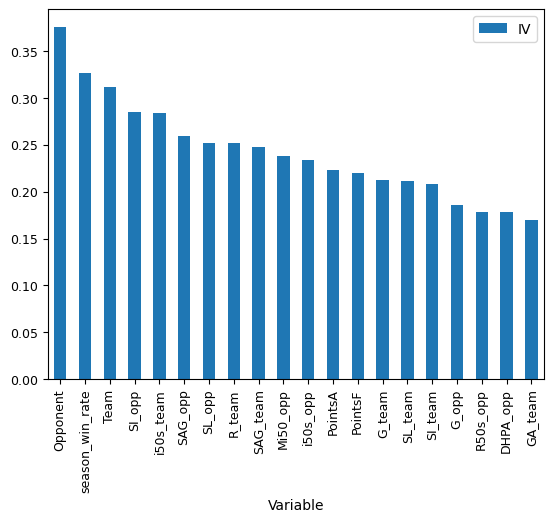

In [10]:
df_IV.head(20).plot.bar(x = 'Variable', y = 'IV', fontsize='9')

### Remove Non Predictors

In [ ]:
#Remover the time based data and points for and against at present match
#Remove Season later after separating into IT/OOT
df_ML = df_matches_v3.drop(['PointsF','PointsA','Round','Date','RoundNum'],axis=1)

## Pre Encoding Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_preprocess(data):
    data_IT = data[data['Season']<=2019]
    data_OOT = data[data['Season']>2019]
    #Get the dependent variable
    y = data_IT.pop('Outcome')
    #Split the in time data, stratify by outcome and shuffle
    X_train, X_test, y_train, y_test = train_test_split(data_IT,y,test_size=0.3,shuffle=True,random_state=5432,stratify=y)
    #Return the split data
    return data_IT, data_OOT, X_train, X_test, y_train, y_test

### Encode Categorical Data

In [ ]:
#Identify and remove the object data and convert to category
df_categories = df_ML.select_dtypes(include=['object']).astype('category')
cat_cols = df_categories.columns
#Remove from the ML data to join back on later
df_ML.drop(cat_cols,axis=1,inplace=True)
#One Hot Encode the categories
df_categories = pd.get_dummies(df_categories,dtype=int)
#Join back on to the df_ML data
df_ML = df_ML.join(df_categories)

### Separate into in Time and OOT

In [ ]:
df_ML_IT, df_ML_OOT, X_train, X_test, y_train, y_test = split_preprocess(df_ML)
#Drop season from all the data
df_ML_IT = df_ML_IT.drop('Season',axis=1)
df_ML_OOT = df_ML_OOT.drop('Season',axis=1)
X_train.drop('Season',axis=1,inplace=True)
X_test.drop('Season',axis=1,inplace=True)

In [ ]:
#Extract Feature names for diagnostics
feature_names = df_ML_IT.columns.to_list()

## Variable Importance

Note that variable importance here is specific to the model we produce with RF. As such, if the model is bad, the feature selection may be useless. Only consider these results in parrallel to the model performance and with other measures such as IVs.

In [ ]:
#Import random forest for variable importance
from sklearn.ensemble import RandomForestClassifier
#Set up model
forest = RandomForestClassifier(random_state=5432)
#Fit the model
forest.fit(X_train,y_train)

#### Check performance on test data

In [ ]:
y_pred = forest.predict(X_test)

confusion_matrix = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Pred'])

In [ ]:
confusion_matrix

**Definitions Reminder:**

- Precision: %Predicted wins that were actually wins.
- Recall: %Wins that were predicted

We want to be sure the predicted wins are correct, precision should be our target metric.

In [ ]:
acc = np.trace(confusion_matrix)/confusion_matrix.sum()
prec = confusion_matrix.loc[1,1]/confusion_matrix.loc[:,1].sum()
rec = confusion_matrix.loc[1,1]/confusion_matrix.loc[1,:].sum()

print('Accuracy: ',acc,'\nPrecision: ',prec*100,'\nRecall: ',rec*100)

Results aren't fantastic, so take the following importances with a grain of salt.

In [ ]:
importances = pd.Series(forest.feature_importances_,index=feature_names)
importances = importances.sort_values(ascending=False)
#Plot the importances
fig, ax = plt.subplots(figsize=(10,5))
importances[0:50].plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Mean accuracy decrease')
fig.tight_layout()
plt.show()

In [ ]:
with pd.option_context('display.max_row',None):
    print(importances)

### Player Stats

At a glance it appears **SI** (Score Involvement), **SL** (Score Launches), **R** (Rating Points), **DHPA** (defensive half pressure acts), **SAG** (shots at goal), **i50s** (Inside 50s), **HTA%** (Hitouts to Advantage percent), **HTW%** (Hitouts to Win percent), **KE%** (kick efficiency), **KHB** (kick to handball ratio), **CP** (contested possessions), **Mi50** (Marks Inside 50), **GA%** (shots at goal accuracy), **CDL%** (contested defensive losses) are important player stats.

### Weather Data

**Max/Min Temp**, **Solar Radiation**, **Wind Speed** seem important, however **Rain** and **Humidity** do not.

### Other

**Attendance** seems very important. Keep **home/away** as well, but seems less important. **Venue**, **Team**, **Opponent** and **Day** to be quite unimportant. 

## Information Values:

Get the information values for all variables, binning the numerical varaibles into deciles.

In [ ]:
df_matches_v3_IT, df_matches_v3_OOT, Xv2_train, Xv2_test, yv2_train, yv2_test = split_preprocess(df_matches_v3)
#Drop season from all the data
df_matches_v3_IT = df_matches_v3_IT.drop(['PointsF','PointsA','Round','Date','RoundNum','Season'],axis=1)
df_matches_v3_OOT = df_matches_v3_OOT.drop(['PointsF','PointsA','Round','Date','RoundNum','Season'],axis=1)
Xv2_train.drop(['PointsF','PointsA','Round','Date','RoundNum','Season'],axis=1,inplace=True)
Xv2_test.drop(['PointsF','PointsA','Round','Date','RoundNum','Season'],axis=1,inplace=True)

In [ ]:
#Join the outcome variable back to the data
Xv2_train = pd.concat([Xv2_train,yv2_train],axis=1)

### Bin the numerical variables as quantiles 

In [ ]:
#Get numerical columns
#Extract only ther numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(Xv2_train.select_dtypes(include=numerics).columns)
num_cols.remove('Outcome')

In [ ]:
Xv2_train_copy = Xv2_train.copy(deep=True)

In [ ]:
for col in num_cols:
    try:
        Xv2_train_copy.loc[:,col] = pd.qcut(Xv2_train[col],10,duplicates='drop') 
    except:
        continue

In [ ]:
num_cols = list(Xv2_train.select_dtypes(include=numerics).columns)

In [ ]:
num_cols

## IV Functions

In [ ]:
import sys
sys.path.append('../functions')
from IVfunctions import * 

In [ ]:
df_IV,Xout = IV_summary(Xv2_train_copy,'Outcome')

In [ ]:
df_IV[df_IV['IV']>=0.07].plot.bar(x = 'Variable', y = 'IV', fontsize='9')

Seems the important variables are 'Team', 'Opponent', 'SAG', 'SI','SL', 'i50s','R', 'G','DHPA','Mi50'

## Univariate Analysis

In [ ]:
#Extract only the relevant columns
Xv2_train = Xv2_train[['Team','Opponent','SAG_team1','SAG_team2','SAG_team3','SAG_opp1','SAG_opp2','SAG_opp3',
                    'SL_team1','SL_team2','SL_team3','SL_opp1','SL_opp2','SL_opp3',
                    'SI_team1','SI_team2','SI_team3','SI_opp1','SI_opp2','SI_opp3',
                    'i50s_team1','i50s_team2','i50s_team3','i50s_opp1','i50s_opp2','i50s_opp3',
                    'R_team1','R_team2','R_team3','R_opp1','R_opp2','R_opp3',
                    'G_team1','G_team2','G_team3','G_opp1','G_opp2','G_opp3',
                    'DHPA_team1','DHPA_team2','DHPA_team3','DHPA_opp1','DHPA_opp2','DHPA_opp3',
                    'Mi50_team1','Mi50_team2','Mi50_team3','Mi50_opp1','Mi50_opp2','Mi50_opp3','Outcome']]

In [ ]:
#Numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(Xv2_train.select_dtypes(include=numerics).columns)
num_cols.remove('Outcome')
#Category columns
cat_cols = list(Xv2_train.select_dtypes(include='object').columns)


In [ ]:
for col in num_cols:
    #round to 2d.p.'s
    Xv2_train['rounded_'+col] = Xv2_train[col].round(1)
    agg = Xv2_train.groupby('rounded_'+col).agg({'Outcome':'mean'})
    agg = agg.sort_index()
    agg = agg.reset_index()
    fig,ax = plt.subplots()
    agg.plot(x='rounded_'+col,y='Outcome',ax=ax)
    plt.show()

### Summary

Team Positive relationships:
- SAG
- SL
- SI
- i50s
- R
- G
- Mi50s

Team Negative relationships:
- DHPA

In [ ]:
#Remove the rounded columns created from earlier
rounded_cols = Xv2_train.columns[Xv2_train.columns.str.match(r'^rounded_')].to_list()

#Remove from the dataframe
Xv2_train=Xv2_train.drop(rounded_cols,axis=1)

In [ ]:
for col in cat_cols:
    #round to 2d.p.'s
    agg = Xv2_train.groupby(col).agg({'Outcome':'mean'})
    agg = agg.sort_values('Outcome')
    agg = agg.reset_index()
    fig,ax = plt.subplots()
    agg.plot.bar(x=col,y='Outcome',ax=ax)
    plt.show()

## Use Decision Tree to find Optimal Cut Points for Numeric Variables

In [ ]:
Xv2_train.pop('Outcome')

## Get Correlations between remaining variables

In [ ]:
dep_vars = ['SAG_team1','SAG_opp3','SL_team1','SL_opp3',\
                       'SI_team1','SI_team2','SI_team3','SI_opp1','SI_opp2',\
                       'SI_opp3','i50s_team1','i50s_team3','R_team3']

corr = Xv2_train[dep_vars].corr()

corr.style.background_gradient(cmap='coolwarm')

**High correlations >80%:**

- SAG_team1 and SL_team1 SI_team1 
- SAG_opp3 and SL_opp3 SI_opp3
- SL and SI.



**Moderate Correlation > 60%:**
- SAG_team1 and i50s_team1
- SL and i50s
- SI and R i50s
- i50s and R

Conclusion: Remove **SI**, **SL**, and **R**

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3,random_state=5432)

In [ ]:
for col in num_cols:
    clf.fit(Xv2_train[col].values.reshape(-1,1),yv2_train)
    fig,ax = plt.subplots(figsize=(10,10))
    fig.suptitle(col)
    tree.plot_tree(clf,ax=ax)
    plt.show()

## Bin the Numeric variables

In [ ]:
# SAG
bins_SAG = pd.IntervalIndex.from_tuples([(-np.inf, 0.8), (0.8, 1.0), (1.0, 1.25),(1.25,1.5),(1.5,np.inf)])
Xv2_train['SAG_team1_binned'] = pd.cut(Xv2_train['SAG_team1'],bins_SAG)
Xv2_train['SAG_team2_binned'] = pd.cut(Xv2_train['SAG_team2'],bins_SAG)
Xv2_train['SAG_team3_binned'] = pd.cut(Xv2_train['SAG_team3'],bins_SAG)
Xv2_train['SAG_opp1_binned'] = pd.cut(Xv2_train['SAG_opp1'],bins_SAG)
Xv2_train['SAG_opp2_binned'] = pd.cut(Xv2_train['SAG_opp2'],bins_SAG)
Xv2_train['SAG_opp3_binned'] = pd.cut(Xv2_train['SAG_opp3'],bins_SAG)

#SL
bins_SL = pd.IntervalIndex.from_tuples([(-np.inf, 0.8),(0.8, 1.5),(1.5,1.7),(1.7,np.inf)])
Xv2_train['SL_team1_binned'] = pd.cut(Xv2_train['SL_team1'],bins_SL)
Xv2_train['SL_team2_binned'] = pd.cut(Xv2_train['SL_team2'],bins_SL)
Xv2_train['SL_team3_binned'] = pd.cut(Xv2_train['SL_team3'],bins_SL)
Xv2_train['SL_opp1_binned'] = pd.cut(Xv2_train['SL_opp1'],bins_SL)
Xv2_train['SL_opp2_binned'] = pd.cut(Xv2_train['SL_opp2'],bins_SL)
Xv2_train['SL_opp3_binned'] = pd.cut(Xv2_train['SL_opp3'],bins_SL)

#SI
bins_SI = pd.IntervalIndex.from_tuples([(-np.inf, 2.5), (2.5, 3.0),(3.0, 4.5),(4.5,5.5),(5.5,np.inf)])
Xv2_train['SI_team1_binned'] = pd.cut(Xv2_train['SI_team1'],bins_SI)
Xv2_train['SI_team2_binned'] = pd.cut(Xv2_train['SI_team2'],bins_SI)
Xv2_train['SI_team3_binned'] = pd.cut(Xv2_train['SI_team3'],bins_SI)
Xv2_train['SI_opp1_binned'] = pd.cut(Xv2_train['SI_opp1'],bins_SI)
Xv2_train['SI_opp2_binned'] = pd.cut(Xv2_train['SI_opp2'],bins_SI)
Xv2_train['SI_opp3_binned'] = pd.cut(Xv2_train['SI_opp3'],bins_SI)

#i50s
bins_i50s = pd.IntervalIndex.from_tuples([(-np.inf, 1.5), (1.5, 1.9),(1.9, 2.5),(2.5,3),(3,np.inf)])
Xv2_train['i50s_team1_binned'] = pd.cut(Xv2_train['i50s_team1'],bins_i50s)
Xv2_train['i50s_team2_binned'] = pd.cut(Xv2_train['i50s_team2'],bins_i50s)
Xv2_train['i50s_team3_binned'] = pd.cut(Xv2_train['i50s_team3'],bins_i50s)
Xv2_train['i50s_opp1_binned'] = pd.cut(Xv2_train['i50s_opp1'],bins_i50s)
Xv2_train['i50s_opp2_binned'] = pd.cut(Xv2_train['i50s_opp2'],bins_i50s)
Xv2_train['i50s_opp3_binned'] = pd.cut(Xv2_train['i50s_opp3'],bins_i50s)

#R
bins_R = pd.IntervalIndex.from_tuples([(-np.inf, 7.5), (7.5, 8.5),(8.5, 10),(10,12),(12,np.inf)])
Xv2_train['R_team1_binned'] = pd.cut(Xv2_train['R_team1'],bins_R)
Xv2_train['R_team2_binned'] = pd.cut(Xv2_train['R_team2'],bins_R)
Xv2_train['R_team3_binned'] = pd.cut(Xv2_train['R_team3'],bins_R)
Xv2_train['R_opp1_binned'] = pd.cut(Xv2_train['R_opp1'],bins_R)
Xv2_train['R_opp2_binned'] = pd.cut(Xv2_train['R_opp2'],bins_R)
Xv2_train['R_opp3_binned'] = pd.cut(Xv2_train['R_opp3'],bins_R)

#G
bins_G = pd.IntervalIndex.from_tuples([(-np.inf, 0.25), (0.25, 0.35),(0.35, 0.45),(0.45,0.6),(0.6,np.inf)])
Xv2_train['G_team1_binned'] = pd.cut(Xv2_train['G_team1'],bins_G)
Xv2_train['G_team2_binned'] = pd.cut(Xv2_train['G_team2'],bins_G)
Xv2_train['G_team3_binned'] = pd.cut(Xv2_train['G_team3'],bins_G)
Xv2_train['G_opp1_binned'] = pd.cut(Xv2_train['G_opp1'],bins_G)
Xv2_train['G_opp2_binned'] = pd.cut(Xv2_train['G_opp2'],bins_G)
Xv2_train['G_opp3_binned'] = pd.cut(Xv2_train['G_opp3'],bins_G)

#DHPA
bins_DHPA = pd.IntervalIndex.from_tuples([(-np.inf, 4.5), (4.5, 5.5),(5.5, 6.5),(6.5,7.5),(7.5,np.inf)])
Xv2_train['DHPA_team1_binned'] = pd.cut(Xv2_train['DHPA_team1'],bins_DHPA)
Xv2_train['DHPA_team2_binned'] = pd.cut(Xv2_train['DHPA_team2'],bins_DHPA)
Xv2_train['DHPA_team3_binned'] = pd.cut(Xv2_train['DHPA_team3'],bins_DHPA)
Xv2_train['DHPA_opp1_binned'] = pd.cut(Xv2_train['DHPA_opp1'],bins_DHPA)
Xv2_train['DHPA_opp2_binned'] = pd.cut(Xv2_train['DHPA_opp2'],bins_DHPA)
Xv2_train['DHPA_opp3_binned'] = pd.cut(Xv2_train['DHPA_opp3'],bins_DHPA)

#Mi50
bins_Mi50 = pd.IntervalIndex.from_tuples([(-np.inf, 4.5), (4.5, 5.5),(5.5, 6.5),(6.5,7.5),(7.5,np.inf)])
Xv2_train['Mi50_team1_binned'] = pd.cut(Xv2_train['Mi50_team1'],bins_Mi50)
Xv2_train['Mi50_team2_binned'] = pd.cut(Xv2_train['Mi50_team2'],bins_Mi50)
Xv2_train['Mi50_team3_binned'] = pd.cut(Xv2_train['Mi50_team3'],bins_Mi50)
Xv2_train['Mi50_opp1_binned'] = pd.cut(Xv2_train['Mi50_opp1'],bins_Mi50)
Xv2_train['Mi50_opp2_binned'] = pd.cut(Xv2_train['Mi50_opp2'],bins_Mi50)
Xv2_train['Mi50_opp3_binned'] = pd.cut(Xv2_train['Mi50_opp3'],bins_Mi50)

In [ ]:
#Join back on the outcome variable
Xv2_train = pd.concat([Xv2_train,yv2_train],axis=1)

## Logistic Regression

In [ ]:
#Xv2_train = Xv2_train.drop('Outcome',axis=1)

In [ ]:
import statsmodels.formula.api as smf
log_reg = smf.logit("Outcome ~ \
SAG_opp3 +\
i50s_team1 + i50s_team3 + Team + Opponent", data=Xv2_train).fit()

In [ ]:
print(log_reg.summary())

# Training Data

In [ ]:
ypred = log_reg.predict(Xv2_train)

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr, thresholds = roc_curve(yv2_train,ypred)

In [ ]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Training ROC Curve')

### ROC SCORE and Gini SCORE

In [ ]:
AUC = roc_auc_score(yv2_train,ypred)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

## Test Data

In [ ]:
ypred_test = log_reg.predict(Xv2_test)
fpr,tpr, thresholds = roc_curve(yv2_test,ypred_test)

In [ ]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Test ROC Curve')

In [ ]:
AUC = roc_auc_score(yv2_test,ypred_test)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)

## Out of Time Data

In [ ]:
y_pred_OOT = log_reg.predict(df_matches_v3_OOT)
y_OOT = df_matches_v3_OOT['Outcome']
fpr,tpr, thresholds = roc_curve(y_OOT,y_pred_OOT)

In [ ]:
fig,ax = plt.subplots()

ax.axline((0,0),slope=1,color='red',linestyle='--')
ax.plot(fpr,tpr)
ax.set_xlabel('TPR')
ax.set_ylabel('FPR')
ax.set_title('Test ROC Curve')

In [ ]:
AUC = roc_auc_score(y_OOT,y_pred_OOT)
Gini = 2*AUC-1
print('ROC AUC: ',AUC*100,'\nGini: ',Gini*100)